# Introduction

1. **Translation Model**:
In this project, the initial focus is on implementing a Translation Model. This component aims to facilitate language translation, using the Seamless model.

2. **ClipCap Model**:
The second major section involves the creation of a Captioner model utilizing CLIP. This model is designed to generate captions, in response to visual input.

3. **ClipCap + Translation**:
The final part of the notebook combines the capabilities of the ClipCap model with the Translation Model. This integration suggests a comprehensive solution where CLIP-generated captions are subsequently translated into Farsi using the Seamless model.

# Imports

In [ ]:
!pip install transformers
!pip install sentencepiece
!pip install open-flamingo
!pip install git+https://github.com/openai/CLIP.git

In [ ]:
import os
import clip
import torch
import PIL.Image
import numpy as np
from torch import nn
from enum import Enum
import skimage.io as io
import torch.nn.functional as nnf
from typing import Tuple, List, Union, Optional
from transformers import AutoProcessor, SeamlessM4TModel
from transformers import GPT2Tokenizer, GPT2LMHeadModel, AdamW, get_linear_schedule_with_warmup
from tqdm import tqdm

/usr/local/lib/python3.10/dist-packages/transformers/deepspeed.py:23: FutureWarning: transformers.deepspeed module is deprecated and will be removed in a future version. Please import deepspeed modules directly from transformers.integrations
  warnings.warn(


# Drive Downloader

In [ ]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

download_with_pydrive = True

class Downloader(object):
    def __init__(self, use_pydrive):
        self.use_pydrive = use_pydrive

        if self.use_pydrive:
            self.authenticate()

    def authenticate(self):
        auth.authenticate_user()
        gauth = GoogleAuth()
        gauth.credentials = GoogleCredentials.get_application_default()
        self.drive = GoogleDrive(gauth)

    def download_file(self, file_id, file_dst):
        if self.use_pydrive:
            downloaded = self.drive.CreateFile({'id':file_id})
            downloaded.FetchMetadata(fetch_all=True)
            downloaded.GetContentFile(file_dst)
        else:
            !gdown --id $file_id -O $file_dst

downloader = Downloader(download_with_pydrive)

# Translation

In this segment, our objective is to employ a pre-existing translation model for converting text between English and Farsi. Your task is to finalize the provided functions and test them on the provided texts.

In [ ]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"

processor = AutoProcessor.from_pretrained("facebook/hf-seamless-m4t-medium")
trans_model = SeamlessM4TModel.from_pretrained("facebook/hf-seamless-m4t-medium")

trans_model = trans_model.to(device)

preprocessor_config.json:   0%|          | 0.00/3.36k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/39.0k [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/4.85M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/4.33k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/3.29k [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


config.json:   0%|          | 0.00/2.56k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/4.84G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/5.35k [00:00<?, ?B/s]

In [ ]:
def translate_english_to_persian(text):

    # ======================================= Code =======================================
    text_inputs = processor(text=text, src_lang="eng", return_tensors="pt").to(device)
    text_array = trans_model.generate(**text_inputs, tgt_lang="pes", generate_speech=False)
    translated_text_from_text = processor.decode(text_array[0].tolist()[0], skip_special_tokens=True)
    # ======================================= Code =======================================

    return translated_text_from_text

In [ ]:
def translate_persian_to_english(text):

    # ======================================= Code =======================================
    text_inputs = processor(text=text, src_lang="pes", return_tensors="pt").to(device)
    text_array = trans_model.generate(**text_inputs, tgt_lang="eng", generate_speech=False)
    translated_text_from_text = processor.decode(text_array[0].tolist()[0], skip_special_tokens=True)
    # ======================================= Code =======================================

    return translated_text_from_text

In [ ]:
translate_english_to_persian('Levi is the best anime character ever!')

'لوي بهترين کاراکتر انيمي تا حالا است!'

In [ ]:
translate_persian_to_english('انسان به منافع هیچ موجودی جز خود نمی‌اندیشد')

'Man has no interest in anything but himself.'

# ClipCap

In this part, our goal is to complete the implementation of the ClipCap model. To achieve this, it's crucial to thoroughly review the associated paper to understant the model's functioning. Please ensure that modifications are solely made within the specified section, avoiding alterations elsewhere in the model to prevent potential issues when loading weights.

## Base Modules

In [1]:
class MappingType(Enum):
    MLP = 'mlp'
    Transformer = 'transformer'


class MlpTransformer(nn.Module):
     def __init__(self, in_dim, h_dim, out_d: Optional[int] = None, act=nnf.relu, dropout=0.):
         super().__init__()
         out_d = out_d if out_d is not None else in_dim
         self.fc1 = nn.Linear(in_dim, h_dim)
         self.act = act
         self.fc2 = nn.Linear(h_dim, out_d)
         self.dropout = nn.Dropout(dropout)

     def forward(self, x):
         x = self.fc1(x)
         x = self.act(x)
         x = self.dropout(x)
         x = self.fc2(x)
         x = self.dropout(x)
         return x

class MLP(nn.Module):

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.model(x)

    def __init__(self, sizes: Tuple[int, ...], bias=True, act=nn.Tanh):
        super(MLP, self).__init__()
        layers = []
        for i in range(len(sizes) - 1):
            layers.append(nn.Linear(sizes[i], sizes[i + 1], bias=bias))
            if i < len(sizes) - 2:
                layers.append(act())
        self.model = nn.Sequential(*layers)


class MultiHeadAttention(nn.Module):

    def __init__(self, dim_self, dim_ref, num_heads, bias=True, dropout=0.):
        super().__init__()
        self.num_heads = num_heads
        head_dim = dim_self // num_heads
        self.scale = head_dim ** -0.5
        self.to_queries = nn.Linear(dim_self, dim_self, bias=bias)
        self.to_keys_values = nn.Linear(dim_ref, dim_self * 2, bias=bias)
        self.project = nn.Linear(dim_self, dim_self)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, y=None, mask=None):
        y = y if y is not None else x
        b, n, c = x.shape
        _, m, d = y.shape
        # b n h dh
        queries = self.to_queries(x).reshape(b, n, self.num_heads, c // self.num_heads)
        # b m 2 h dh
        keys_values = self.to_keys_values(y).reshape(b, m, 2, self.num_heads, c // self.num_heads)
        keys, values = keys_values[:, :, 0], keys_values[:, :, 1]
        attention = torch.einsum('bnhd,bmhd->bnmh', queries, keys) * self.scale
        if mask is not None:
            if mask.dim() == 2:
                mask = mask.unsqueeze(1)
            attention = attention.masked_fill(mask.unsqueeze(3), float("-inf"))
        attention = attention.softmax(dim=2)
        out = torch.einsum('bnmh,bmhd->bnhd', attention, values).reshape(b, n, c)
        out = self.project(out)
        return out, attention


class TransformerLayer(nn.Module):

    def forward_with_attention(self, x, y=None, mask=None):
        x_, attention = self.attn(self.norm1(x), y, mask)
        x = x + x_
        x = x + self.mlp(self.norm2(x))
        return x, attention

    def forward(self, x, y=None, mask=None):
        x = x + self.attn(self.norm1(x), y, mask)[0]
        x = x + self.mlp(self.norm2(x))
        return x

    def __init__(self, dim_self, dim_ref, num_heads, mlp_ratio=4., bias=False, dropout=0., act=nnf.relu,
                 norm_layer: nn.Module = nn.LayerNorm):
        super().__init__()
        self.norm1 = norm_layer(dim_self)
        self.attn = MultiHeadAttention(dim_self, dim_ref, num_heads, bias=bias, dropout=dropout)
        self.norm2 = norm_layer(dim_self)
        self.mlp = MlpTransformer(dim_self, int(dim_self * mlp_ratio), act=act, dropout=dropout)


class Transformer(nn.Module):

    def forward_with_attention(self, x, y=None, mask=None):
        attentions = []
        for layer in self.layers:
            x, att = layer.forward_with_attention(x, y, mask)
            attentions.append(att)
        return x, attentions

    def forward(self, x, y=None, mask=None):
        for i, layer in enumerate(self.layers):
            if i % 2 == 0 and self.enc_dec: # cross
                x = layer(x, y)
            elif self.enc_dec:  # self
                x = layer(x, x, mask)
            else:  # self or cross
                x = layer(x, y, mask)
        return x

    def __init__(self, dim_self: int, num_heads: int, num_layers: int, dim_ref: Optional[int] = None,
                 mlp_ratio: float = 2., act=nnf.relu, norm_layer: nn.Module = nn.LayerNorm, enc_dec: bool = False):
        super(Transformer, self).__init__()
        dim_ref = dim_ref if dim_ref is not None else dim_self
        self.enc_dec = enc_dec
        if enc_dec:
            num_layers = num_layers * 2
        layers = []
        for i in range(num_layers):
            if i % 2 == 0 and enc_dec:  # cross
                layers.append(TransformerLayer(dim_self, dim_ref, num_heads, mlp_ratio, act=act, norm_layer=norm_layer))
            elif enc_dec:  # self
                layers.append(TransformerLayer(dim_self, dim_self, num_heads, mlp_ratio, act=act, norm_layer=norm_layer))
            else:  # self or cross
                layers.append(TransformerLayer(dim_self, dim_ref, num_heads, mlp_ratio, act=act, norm_layer=norm_layer))
        self.layers = nn.ModuleList(layers)


class TransformerMapper(nn.Module):

    def forward(self, x):
        x = self.linear(x).view(x.shape[0], self.clip_length, -1)
        prefix = self.prefix_const.unsqueeze(0).expand(x.shape[0], *self.prefix_const.shape)
        prefix = torch.cat((x, prefix), dim=1)
        out = self.transformer(prefix)[:, self.clip_length:]
        return out

    def __init__(self, dim_clip: int, dim_embedding: int, prefix_length: int, clip_length: int, num_layers: int = 8):
        super(TransformerMapper, self).__init__()
        self.clip_length = clip_length
        self.transformer = Transformer(dim_embedding, 8, num_layers)
        self.linear = nn.Linear(dim_clip, clip_length * dim_embedding)
        self.prefix_const = nn.Parameter(torch.randn(prefix_length, dim_embedding), requires_grad=True)

NameError: name 'Enum' is not defined

## Main Modules

In [ ]:
class ClipCaptionModel(nn.Module):

    def get_dummy_token(self, batch_size: int, device: torch.device) -> torch.Tensor:
        return torch.zeros(batch_size, self.prefix_length, dtype=torch.int64, device=device)

    def __init__(self, prefix_length: int, clip_length: Optional[int] = None, prefix_size: int = 512,
                 num_layers: int = 8, mapping_type: MappingType = MappingType.MLP):
        super(ClipCaptionModel, self).__init__()
        self.prefix_length = prefix_length
        self.gpt = GPT2LMHeadModel.from_pretrained('gpt2')
        self.gpt_embedding_size = self.gpt.transformer.wte.weight.shape[1]
        if mapping_type == MappingType.MLP:
            self.clip_project = MLP((prefix_size, (self.gpt_embedding_size * prefix_length) // 2,
                                     self.gpt_embedding_size * prefix_length))
        else:
            self.clip_project = TransformerMapper(prefix_size, self.gpt_embedding_size, prefix_length,
                                                                     clip_length, num_layers)

    def forward(self, tokens: torch.Tensor, prefix: torch.Tensor, mask: Optional[torch.Tensor] = None,
                labels: Optional[torch.Tensor] = None):

        # ==================================== Code ====================================
        embedding_text = self.gpt.transformer.wte(tokens)
        prefix_projections = self.clip_project(prefix).view(-1, self.prefix_length, self.gpt_embedding_size)
        embedding_cat = torch.cat((prefix_projections, embedding_text), dim=1)
        if labels is not None:
            dummy_token = self.get_dummy_token(tokens.shape[0], tokens.device)
            labels = torch.cat((dummy_token, tokens), dim=1)
        out = self.gpt(inputs_embeds=embedding_cat, labels=labels, attention_mask=mask)
        # ==================================== Code ====================================

        return out

class ClipCaptionPrefix(ClipCaptionModel):

    def parameters(self, recurse: bool = True):
        return self.clip_project.parameters()

    def train(self, mode: bool = True):
        super(ClipCaptionPrefix, self).train(mode)
        self.gpt.eval()
        return self

## Caption Generation Functions

In this section, you are to implement two decoding strategies, specifically, both greedy and beam search. Your task involves completing the provided functions dedicated to these strategies.

In [ ]:
def generate_beam(model, tokenizer, beam_size: int = 5, prompt=None, embed=None,
                  entry_length=67, temperature=1., stop_token: str = '.'):

    # ==================================== Code (Begin) ====================================
    model.eval()
    stop_token_index = tokenizer.encode(stop_token)[0]
    tokens = None
    scores = None
    device = next(model.parameters()).device
    seq_lengths = torch.ones(beam_size, device=device)
    is_stopped = torch.zeros(beam_size, device=device, dtype=torch.bool)
    with torch.no_grad():
        if embed is not None:
            generated = embed
        else:
            if tokens is None:
                tokens = torch.tensor(tokenizer.encode(prompt))
                tokens = tokens.unsqueeze(0).to(device)
                generated = model.gpt.transformer.wte(tokens)
        for i in range(entry_length):
            outputs = model.gpt(inputs_embeds=generated)
            logits = outputs.logits
            logits = logits[:, -1, :] / (temperature if temperature > 0 else 1.0)
            logits = logits.softmax(-1).log()
            if scores is None:
                scores, next_tokens = logits.topk(beam_size, -1)
                generated = generated.expand(beam_size, *generated.shape[1:])
                next_tokens, scores = next_tokens.permute(1, 0), scores.squeeze(0)
                if tokens is None:
                    tokens = next_tokens
                else:
                    tokens = tokens.expand(beam_size, *tokens.shape[1:])
                    tokens = torch.cat((tokens, next_tokens), dim=1)
            else:
                logits[is_stopped] = -float(np.inf)
                logits[is_stopped, 0] = 0
                scores_sum = scores[:, None] + logits
                seq_lengths[~is_stopped] += 1
                scores_sum_average = scores_sum / seq_lengths[:, None]
                scores_sum_average, next_tokens = scores_sum_average.view(-1).topk(
                    beam_size, -1
                )
                next_tokens_source = next_tokens // scores_sum.shape[1]
                seq_lengths = seq_lengths[next_tokens_source]
                next_tokens = next_tokens % scores_sum.shape[1]
                next_tokens = next_tokens.unsqueeze(1)
                tokens = tokens[next_tokens_source]
                tokens = torch.cat((tokens, next_tokens), dim=1)
                generated = generated[next_tokens_source]
                scores = scores_sum_average * seq_lengths
                is_stopped = is_stopped[next_tokens_source]
            next_token_embed = model.gpt.transformer.wte(next_tokens.squeeze()).view(
                generated.shape[0], 1, -1
            )
            generated = torch.cat((generated, next_token_embed), dim=1)
            is_stopped = is_stopped + next_tokens.eq(stop_token_index).squeeze()
            if is_stopped.all():
                break
    scores = scores / seq_lengths
    output_list = tokens.cpu().numpy()
    output_texts = [
        tokenizer.decode(output[: int(length)])
        for output, length in zip(output_list, seq_lengths)
    ]
    order = scores.argsort(descending=True)
    output_texts = [output_texts[i] for i in order]
    return output_texts
    # ==================================== Code (End) ====================================

def generate_simple(
        model,
        tokenizer,
        tokens=None,
        prompt=None,
        embed=None,
        entry_count=1,
        entry_length=67,  # maximum number of words
        top_p=0.8,
        temperature=1.,
        stop_token: str = '.',
):

    # ==================================== Code (Begin) ====================================
    model.eval()
    generated_num = 0
    generated_list = []
    stop_token_index = tokenizer.encode(stop_token)[0]
    filter_value = -float("Inf")
    device = next(model.parameters()).device

    with torch.no_grad():

        for entry_idx in range(entry_count):
            if embed is not None:
                generated = embed
            else:
                if tokens is None:
                    tokens = torch.tensor(tokenizer.encode(prompt))
                    tokens = tokens.unsqueeze(0).to(device)

                generated = model.gpt.transformer.wte(tokens)

            for i in range(entry_length):

                outputs = model.gpt(inputs_embeds=generated)
                logits = outputs.logits
                logits = logits[:, -1, :] / (temperature if temperature > 0 else 1.0)
                sorted_logits, sorted_indices = torch.sort(logits, descending=True)
                cumulative_probs = torch.cumsum(
                    nnf.softmax(sorted_logits, dim=-1), dim=-1
                )
                sorted_indices_to_remove = cumulative_probs > top_p
                sorted_indices_to_remove[..., 1:] = sorted_indices_to_remove[
                    ..., :-1
                ].clone()
                sorted_indices_to_remove[..., 0] = 0

                indices_to_remove = sorted_indices[sorted_indices_to_remove]
                logits[:, indices_to_remove] = filter_value
                next_token = torch.argmax(logits, -1).unsqueeze(0)
                next_token_embed = model.gpt.transformer.wte(next_token)
                if tokens is None:
                    tokens = next_token
                else:
                    tokens = torch.cat((tokens, next_token), dim=1)
                generated = torch.cat((generated, next_token_embed), dim=1)
                if stop_token_index == next_token.item():
                    break

            output_list = list(tokens.squeeze().cpu().numpy())
            output_text = tokenizer.decode(output_list)
            generated_list.append(output_text)

    return generated_list[0]
    # ==================================== Code (End) ====================================

## Generate

In [ ]:
pretrained_model = 'COCO'
model_path = './model_wieghts.pt'
current_directory = os.getcwd()

downloader.download_file("1GYPToCqFREwi285wPLhuVExlz7DDUDfJ", model_path)
is_gpu = torch.cuda.is_available()
device = 'cuda:0' if is_gpu else "cpu"
clip_model, preprocess = clip.load("RN50x4", device=device, jit=False)
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")

100%|███████████████████████████████████████| 402M/402M [00:13<00:00, 32.1MiB/s]


vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

In [ ]:
prefix_length = 40
model = ClipCaptionPrefix(prefix_length, clip_length=40, prefix_size=640, num_layers=8, mapping_type='transformer')
model.load_state_dict(torch.load(model_path, map_location='cpu'), strict=False)
model = model.eval()
model = model.to(device)

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

In [ ]:
# ['562207', '579664', '060623', '165547', '334321', '483108', '386164', '354533']
IMAGE_NAME = '334321'

name_ = "COCO_val2014_000000" + IMAGE_NAME + ".jpg"
images_path = os.path.join(os.path.dirname(current_directory), "images")
os.makedirs(images_path, exist_ok=True)
UPLOADED_FILE = os.path.join(images_path, name_)

if not os.path.isfile(UPLOADED_FILE):
  download_path = os.path.join(images_path, "images.zip")
  downloader.download_file("1l6J9WFYxpF-1HFr3A5Oq1eoObTxzbPgs", download_path)
  !unzip {download_path} -d {images_path}

Archive:  /images/images.zip
  inflating: /images/COCO_val2014_000000060623.jpg  
  inflating: /images/__MACOSX/._COCO_val2014_000000060623.jpg  
  inflating: /images/COCO_val2014_000000165547.jpg  
  inflating: /images/__MACOSX/._COCO_val2014_000000165547.jpg  
  inflating: /images/COCO_val2014_000000334321.jpg  
  inflating: /images/__MACOSX/._COCO_val2014_000000334321.jpg  
  inflating: /images/COCO_val2014_000000354533.jpg  
  inflating: /images/__MACOSX/._COCO_val2014_000000354533.jpg  
  inflating: /images/COCO_val2014_000000386164.jpg  
  inflating: /images/__MACOSX/._COCO_val2014_000000386164.jpg  
  inflating: /images/COCO_val2014_000000483108.jpg  
  inflating: /images/__MACOSX/._COCO_val2014_000000483108.jpg  
  inflating: /images/COCO_val2014_000000562207.jpg  
  inflating: /images/__MACOSX/._COCO_val2014_000000562207.jpg  
  inflating: /images/COCO_val2014_000000579664.jpg  
  inflating: /images/__MACOSX/._COCO_val2014_000000579664.jpg  


In the next cell use the ClipCap model to generate captions for the image.

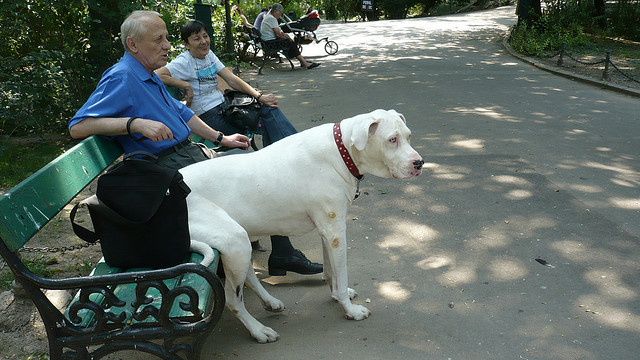

Caption generated using beam search :  A couple of people sitting on a bench next to a white horse.
Caption generated using simple generation :  A white dog and a couple of people sitting on a bench.


In [ ]:
use_beam_search = True
image = io.imread(UPLOADED_FILE)
pil_image = PIL.Image.fromarray(image)
display(pil_image)

# ==================================== Code (Begin) ====================================
image = preprocess(pil_image).unsqueeze(0).to(device)
with torch.no_grad():
    prefix = clip_model.encode_image(image).to(device, dtype=torch.float32)
    prefix_embed = model.clip_project(prefix).reshape(1, prefix_length, -1)

print('Caption generated using beam search : ', generate_beam(model, tokenizer, embed=prefix_embed)[0])
print('Caption generated using simple generation : ', generate_simple(model, tokenizer, embed=prefix_embed))
# ==================================== Code (End) ====================================

# ClipCap + Seamless

Finally, your task is to employ the Seamless model to translate the generated captions into Farsi.

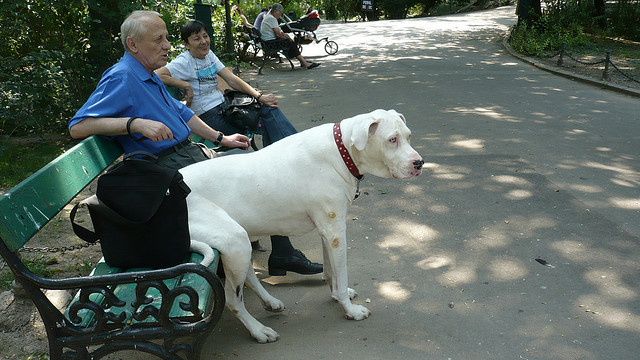

Caption generated using beam search :  چند نفر روی نیمکت کنار یک اسب سفید نشسته اند.
Caption generated using simple generation :  یک سگ سفید و چند نفر روی یک نیمکت نشسته اند.


In [ ]:
# ==================================== Code (Begin) ====================================
use_beam_search = True
image = io.imread(UPLOADED_FILE)
pil_image = PIL.Image.fromarray(image)
display(pil_image)

image = preprocess(pil_image).unsqueeze(0).to(device)
with torch.no_grad():
    prefix = clip_model.encode_image(image).to(device, dtype=torch.float32)
    prefix_embed = model.clip_project(prefix).reshape(1, prefix_length, -1)

print('Caption generated using beam search : ', translate_english_to_persian(generate_beam(model, tokenizer, embed=prefix_embed)[0]))
print('Caption generated using simple generation : ', translate_english_to_persian(generate_simple(model, tokenizer, embed=prefix_embed)))
# ==================================== Code (End) ====================================

# Evaluation

In order to evaluate your model, first you need to prepare a dataset with 100 pairs of image and Farsi captions. For this you can use the images and captions available in the COCO dataset (you need to translate the captions to Farsi). Then use your model to predict captions for the images and finally use common metrics such as BLEU to evaluate your model.

In [ ]:
!wget http://images.cocodataset.org/zips/val2014.zip
!unzip val2014.zip
!rm val2014.zip

In [ ]:
!wget http://images.cocodataset.org/annotations/annotations_trainval2014.zip
!unzip annotations_trainval2014.zip
!rm annotations_trainval2014.zip

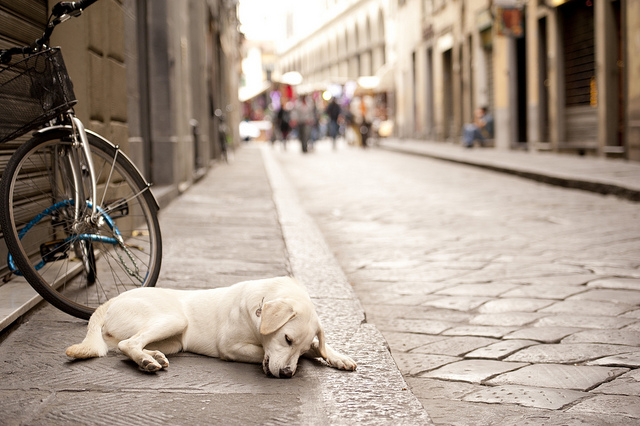

Caption generated using beam search :  A white dog laying next to a bicycle on a sidewalk.
Caption generated using simple generation :  A dog laying on the ground next to a bicycle.


In [ ]:
use_beam_search = True
image = io.imread('./val2014/COCO_val2014_000000000074.jpg')
pil_image = PIL.Image.fromarray(image)
display(pil_image)

image = preprocess(pil_image).unsqueeze(0).to(device)
with torch.no_grad():
    prefix = clip_model.encode_image(image).to(device, dtype=torch.float32)
    prefix_embed = model.clip_project(prefix).reshape(1, prefix_length, -1)

print('Caption generated using beam search : ', generate_beam(model, tokenizer, embed=prefix_embed)[0])
print('Caption generated using simple generation : ', generate_simple(model, tokenizer, embed=prefix_embed))

In [ ]:
from collections import defaultdict
import json
import numpy as np

class COCOParser:
    def __init__(self, anns_file, imgs_dir):
        with open(anns_file, 'r') as f:
            coco = json.load(f)
        self.imgs_dir = imgs_dir
        self.annIm_dict = defaultdict(list)
        self.annId_dict = {}
        self.im_dict = {}
        for ann in coco['annotations']:
            self.annIm_dict[ann['image_id']].append(ann)
            self.annId_dict[ann['id']]=ann
        for img in coco['images']:
            self.im_dict[img['id']] = img
    def get_imgIds(self):
        return list(self.im_dict.keys())
    def get_annIds(self, im_ids):
        im_ids=im_ids if isinstance(im_ids, list) else [im_ids]
        return [ann['id'] for im_id in im_ids for ann in self.annIm_dict[im_id]]
    def load_anns(self, ann_ids):
        im_ids=ann_ids if isinstance(ann_ids, list) else [ann_ids]
        return [self.annId_dict[ann_id] for ann_id in ann_ids]
    def load_cats(self, class_ids):
        class_ids=class_ids if isinstance(class_ids, list) else [class_ids]
        return [self.cat_dict[class_id] for class_id in class_ids]
    def get_imgPaths(self, im_ids):
        im_ids=im_ids if isinstance(im_ids, list) else [im_ids]
        imgPaths = []
        for im_id in im_ids:
          im_id = str(im_id)
          id_len = len(str(im_id))
          name_ = "COCO_val2014_" + '0'*(12-id_len) + im_id + ".jpg"
          imgPaths.append(self.imgs_dir + '/' + name_)
        return imgPaths

In [ ]:
coco_annotations_file = "./annotations/captions_val2014.json"
coco_images_dir = "./val2014"
coco = COCOParser(coco_annotations_file, coco_images_dir)

In [ ]:
np.random.seed(21)

dataset = []
random_imgIds = list(np.random.choice(coco.get_imgIds(), 100))
imgPaths = coco.get_imgPaths(random_imgIds)

for i, imgId in tqdm(enumerate(random_imgIds)):
    annIds = coco.get_annIds(imgId)
    anns = coco.load_anns(annIds)
    for ann in anns:
      ann['persian_caption'] = translate_english_to_persian(ann['caption'])
    dataset.append({"image_path": imgPaths[i], "annotations": anns})

100it [02:19,  1.39s/it]


In [ ]:
dataset[0]

{'image_path': './val2014/COCO_val2014_000000525286.jpg',
 'annotations': [{'image_id': 525286,
   'id': 627885,
   'caption': 'A large clock  is on the wall where the paint is peeling.',
   'persian_caption': 'یک ساعت بزرگ روی دیوار است که در آن رنگ در حال پوست شدن است.'},
  {'image_id': 525286,
   'id': 634050,
   'caption': 'A thermometer near a tiled wall beneath trees.',
   'persian_caption': 'یک ترمومتر در نزدیکی یک دیوار کاشی شده زیر درختان.'},
  {'image_id': 525286,
   'id': 634959,
   'caption': "A measuring instrument hanging on the wall of a building who's paint is chipping.",
   'persian_caption': 'یک ابزار اندازه گیری که روی دیوار یک ساختمان آویزان شده است که رنگش شکسته شده است.'},
  {'image_id': 525286,
   'id': 640179,
   'caption': 'This is a temperature gauge that is hanging outdoors. ',
   'persian_caption': 'این یک اندازه گیری دمای است که در فضای باز آویزان است.'},
  {'image_id': 525286,
   'id': 640629,
   'caption': 'A clock hangs on a wall of a neglected building.

In [ ]:
with torch.no_grad():
  for data in tqdm(dataset):
    img_path = data['image_path']
    image = io.imread(img_path)
    pil_image = PIL.Image.fromarray(image)
    image = preprocess(pil_image).unsqueeze(0).to(device)
    prefix = clip_model.encode_image(image).to(device, dtype=torch.float32)
    prefix_embed = model.clip_project(prefix).reshape(1, prefix_length, -1)
    en_beam_pred = generate_beam(model, tokenizer, embed=prefix_embed)[0]
    en_simple_pred = generate_simple(model, tokenizer, embed=prefix_embed)
    per_beam_pred = translate_english_to_persian(en_beam_pred)
    per_simple_pred = translate_english_to_persian(en_simple_pred)
    data['predictions'] = [{'en_beam_search':en_beam_pred}, {'en_simple_search':en_simple_pred},
                           {'per_beam_search':per_beam_pred}, {'per_simple_search':per_simple_pred}]

100%|██████████| 100/100 [01:38<00:00,  1.02it/s]


In [ ]:
dataset[0]

{'image_path': './val2014/COCO_val2014_000000525286.jpg',
 'annotations': [{'image_id': 525286,
   'id': 627885,
   'caption': 'A large clock  is on the wall where the paint is peeling.',
   'persian_caption': 'یک ساعت بزرگ روی دیوار است که در آن رنگ در حال پوست شدن است.'},
  {'image_id': 525286,
   'id': 634050,
   'caption': 'A thermometer near a tiled wall beneath trees.',
   'persian_caption': 'یک ترمومتر در نزدیکی یک دیوار کاشی شده زیر درختان.'},
  {'image_id': 525286,
   'id': 634959,
   'caption': "A measuring instrument hanging on the wall of a building who's paint is chipping.",
   'persian_caption': 'یک ابزار اندازه گیری که روی دیوار یک ساختمان آویزان شده است که رنگش شکسته شده است.'},
  {'image_id': 525286,
   'id': 640179,
   'caption': 'This is a temperature gauge that is hanging outdoors. ',
   'persian_caption': 'این یک اندازه گیری دمای است که در فضای باز آویزان است.'},
  {'image_id': 525286,
   'id': 640629,
   'caption': 'A clock hangs on a wall of a neglected building.

In [ ]:
beam_predictions = [data['predictions'][2]['per_beam_search'] for data in dataset]
simple_predictions = [data['predictions'][3]['per_simple_search'] for data in dataset]
references = [[[annot['persian_caption']] for annot in data['annotations']] for data in dataset]

In [ ]:
import locale
def getpreferredencoding(do_setlocale = True):
    return "UTF-8"
locale.getpreferredencoding = getpreferredencoding

!pip install evaluate

In [ ]:
import evaluate
from IPython.display import clear_output

bleu = evaluate.load("bleu")
clear_output()

bleu_beam = bleu.compute(predictions=beam_predictions, references=references)
bleu_simple = bleu.compute(predictions=simple_predictions, references=references)

print('BLEU score for beam_search generation : ', bleu_beam)
print('BLEU score for simple_search generation : ', bleu_simple)

BLEU score for beam_search generation :  {'bleu': 0.2385197405931345, 'precisions': [0.7216981132075472, 0.40208333333333335, 0.20930232558139536, 0.09210526315789473], 'brevity_penalty': 0.8721512198664219, 'length_ratio': 0.8796680497925311, 'translation_length': 1060, 'reference_length': 1205}
BLEU score for simple_search generation :  {'bleu': 0.2501559288365535, 'precisions': [0.7478591817316841, 0.41009463722397477, 0.2209165687426557, 0.10386151797603196], 'brevity_penalty': 0.8637023109745191, 'length_ratio': 0.8721991701244813, 'translation_length': 1051, 'reference_length': 1205}


In [ ]:
meteor = evaluate.load('meteor')
clear_output()

meteor_beam = meteor.compute(predictions=beam_predictions, references=references)
meteor_simple = meteor.compute(predictions=simple_predictions, references=references)

print('METEOR score for beam_search generation : ', meteor_beam)
print('METEOR score for simple_search generation : ', meteor_simple)

METEOR score for beam_search generation :  {'meteor': 0.351467834949054}
METEOR score for simple_search generation :  {'meteor': 0.356801057338923}


In [ ]:
!pip install rouge_score

In [ ]:
rouge = evaluate.load('rouge')
clear_output()

rouge_beam = rouge.compute(predictions=beam_predictions, references=references, tokenizer=lambda x: x.split())
rouge_simple = rouge.compute(predictions=simple_predictions, references=references, tokenizer=lambda x: x.split())

print('ROUGE score for beam_search generation : ', rouge_beam)
print('ROUGE score for simple_search generation : ', rouge_simple)

ROUGE score for beam_search generation :  {'rouge1': 0.4405868762955841, 'rouge2': 0.22445789270891228, 'rougeL': 0.4034177954876045, 'rougeLsum': 0.4025430618944077}
ROUGE score for simple_search generation :  {'rouge1': 0.4533547612973913, 'rouge2': 0.2411910769600868, 'rougeL': 0.4154810186493185, 'rougeLsum': 0.4146268860135091}
